<a href="https://colab.research.google.com/github/Daivar/Microsoft_stoct_prediction/blob/main/Microsoft_stoct_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('Microsoft_Stock.csv', infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
df.head

<bound method NDFrame.head of                        Open    High     Low   Close    Volume
Date                                                         
2015-04-01 16:00:00   40.60   40.76   40.31   40.72  36865322
2015-04-02 16:00:00   40.66   40.74   40.12   40.29  37487476
2015-04-06 16:00:00   40.34   41.78   40.18   41.55  39223692
2015-04-07 16:00:00   41.61   41.91   41.31   41.53  28809375
2015-04-08 16:00:00   41.48   41.69   41.04   41.42  24753438
...                     ...     ...     ...     ...       ...
2021-03-25 16:00:00  235.30  236.94  231.57  232.34  34061853
2021-03-26 16:00:00  231.55  236.71  231.55  236.48  25479853
2021-03-29 16:00:00  236.59  236.80  231.88  235.24  25227455
2021-03-30 16:00:00  233.53  233.85  231.10  231.85  24792012
2021-03-31 16:00:00  232.91  239.10  232.39  235.77  43623471

[1511 rows x 5 columns]>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


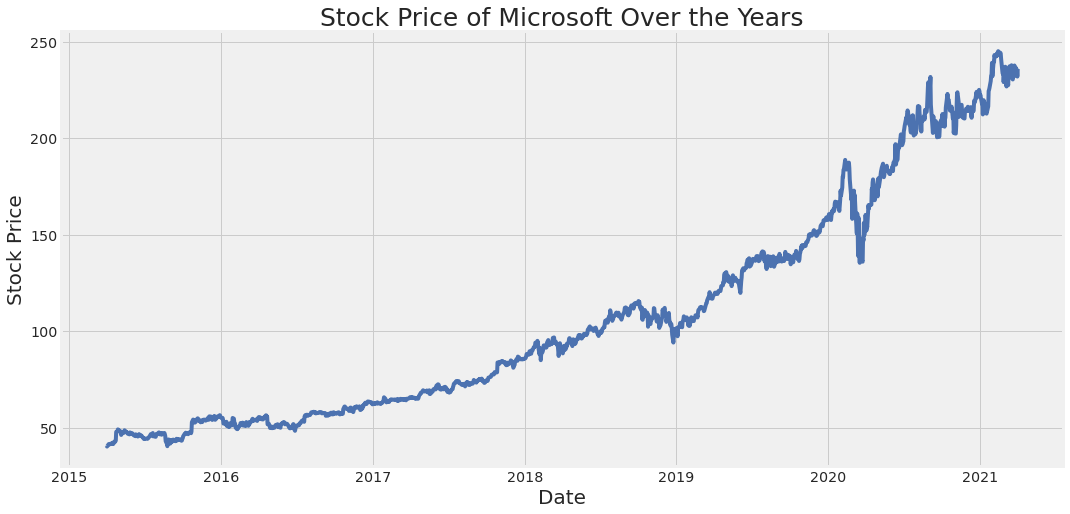

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='b')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Microsoft Over the Years',size=25);

In [8]:
# Normalizes the data
def to_dataset(data):
    data = data.astype('float32')
    #scaler = MinMaxScaler(feature_range=(0,1))
    #return scaler.fit_transform(data)
    return data/255.

# Data train and test
def train_test(data):
    train_size = int(len(data) * 0.75)
    train, test = data[0:train_size, :], data[train_size:len(data), :]
    return train, test

# Time windows - use 10 days to forecast the nest 10 days 
def windows(sequence, step_in, step_out):
    x, y = [], []
    for i in range(len(sequence)):
        end_i = i + step_in
        out_i = end_i + step_out
        if out_i > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_i, :], sequence[end_i:out_i, :]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Model
def creat_model(step_in, step_out, features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(step_in, features)))
    model.add(RepeatVector(step_out))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(features)))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Run all functions
def prepare_training(data, step_in, step_out):
    data = to_dataset(data)
    train, test = train_test(data)
    x_train, x_test = windows(train, step_in, step_out)
    y_train, y_test = windows(test, step_in, step_out)
    features = 1
    return x_train, x_test, y_train, y_test, features

In [38]:
step_in, step_out = 10, 10 
epochs = 50 
batch_size = 32

early = EarlyStopping(monitor='val_loss',patience=5)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [39]:
data = df['Close'].values
data = data.reshape(-1, 1)

In [40]:
x_train, y_train, x_test, y_test, feature = prepare_training(data, step_in, step_out)

In [41]:
model = creat_model(step_in, step_out, feature)

In [42]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=144, verbose=1,
         validation_data=(x_test, y_test), callbacks=[early,reduce])

Epoch 1/50
8/8 [==============================] - 3s 131ms/step - loss: 0.0871 - mean_squared_error: 0.0871 - val_loss: 0.3570 - val_mean_squared_error: 0.3570 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 1s 80ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - val_loss: 0.1326 - val_mean_squared_error: 0.1326 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 1s 83ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.1486 - val_mean_squared_error: 0.1486 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 1s 79ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - lr: 0.0010
Epoch 5/50
8/8 [==============================] - 1s 83ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0794 - val_mean_squared_error: 0.0794 - lr: 0.0010
Epoch 6/50
8/8 [==============================] - 1s 81ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0731 - val_mean_sq

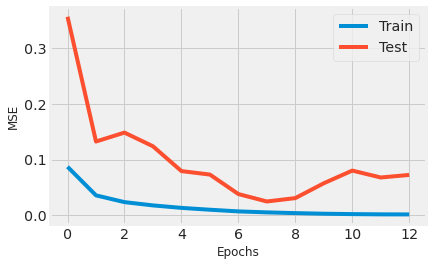

In [43]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Test']);

In [44]:
pred = model.predict(x_test)

In [45]:
x = x_test[0]*255.0
y = pred[0]*255.0

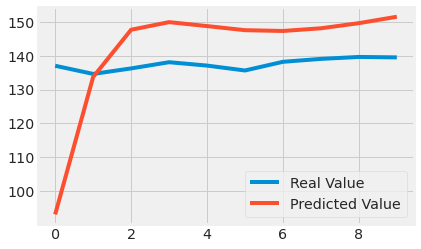

In [46]:
plt.plot(x)
plt.plot(y)
plt.legend(['Real Value','Predicted Value']);